# Analysis of Ariane Qualitative Runs

In [57]:
%matplotlib inline
from matplotlib import pylab
from matplotlib import pyplot as plt, animation
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import xarray as xr
import numpy as np
from salishsea_tools import (nc_tools,viz_tools)
import cmocean as cm
from datetime import datetime
from IPython.display import HTML
import netCDF4 as nc

## test run with SalishSeaCast

In [2]:
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
file = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/salish_qual/forward_01mar19/ariane_trajectories_qualitative.nc')

Text(0, 0.5, 'lat')

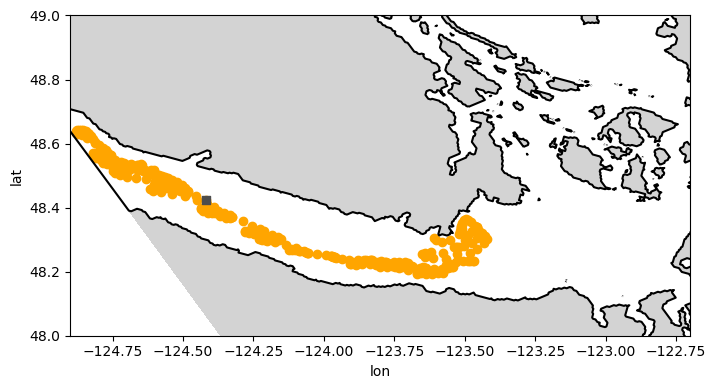

In [3]:
# 2D
fig, ax = plt.subplots(1,1,figsize=(8,4.6))

ax.contourf(mesh.nav_lon, mesh.nav_lat, mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(mesh.nav_lon, mesh.nav_lat, mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-124.9, -122.7])
ax.set_ylim([48, 49])
ax.set_aspect(5/4.4)

ax.scatter(file.traj_lon,file.traj_lat,color='orange')
ax.scatter(file.traj_lon[0],file.traj_lat[0],color='0.30',marker='s')

ax.set_xlabel('lon')
ax.set_ylabel('lat')

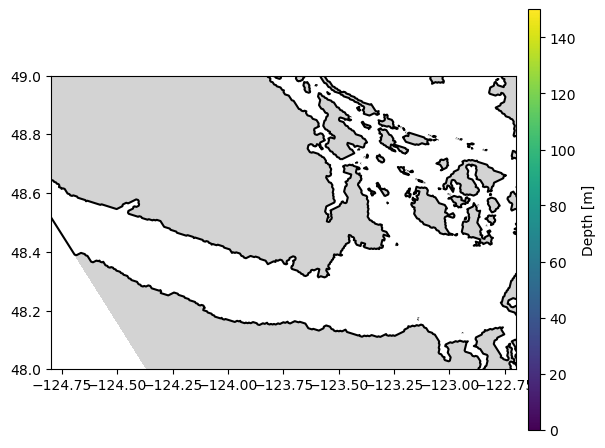

In [4]:
# Make initial animation figure
fig, ax = plt.subplots(figsize=(6, 6))
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
l = ax.scatter([], [], s=50, c=[], vmin=0, vmax=150, edgecolor='k')
t = ax.text(0.02, 0.02, '', transform=ax.transAxes)
ax.contourf(mesh.nav_lon, mesh.nav_lat, mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(mesh.nav_lon, mesh.nav_lat, mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-124.8, -122.7])
ax.set_ylim([48, 49])
ax.set_aspect(1/np.sin(np.deg2rad(49)))
fig.colorbar(l, cax=cax, label='Depth [m]')

# Init function
def init():
    t.set_text('')
    l.set_offsets(np.empty((0, 2)))
    l.set_array(np.empty(0))
    return l, t,

# Animate function
def animate(hour):
#     tstamp = file.traj_time[hour, 0].values.astype('datetime64[s]').astype(datetime)
#     t.set_text(tstamp.strftime('%Y-%b-%d %H:%M UTC'))
    l.set_offsets(np.vstack([file.traj_lon[hour,:], file.traj_lat[hour,:]]).T)
    l.set_array(file.traj_depth[hour,:])
    return l, t,

# Build animation
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(file.nb_output)-1, interval=100, blit=True)

In [5]:
HTML(anim.to_html5_video())

## CIOPS BC12
#### first: lets make some smart choices about where to put the particles!

In [51]:
# date = datetime(2016,1,1)
# nc_file = "/ocean/rbeutel/data/{:%Y%m}/U_new_{:%Y%m%d}.nc".format(date,date)
nc_file = "/ocean/rbeutel/data/u_new_23Nov15_WithEncodingBasic.nc"
nc_to_plot = xr.open_dataset(nc_file)
mesh = xr.open_dataset('/ocean/mdunphy/CIOPSW-BC12/grid/mesh_mask_Bathymetry_NEP36_714x1020_SRTM30v11_NOAA3sec_WCTSS_JdeFSalSea.nc')

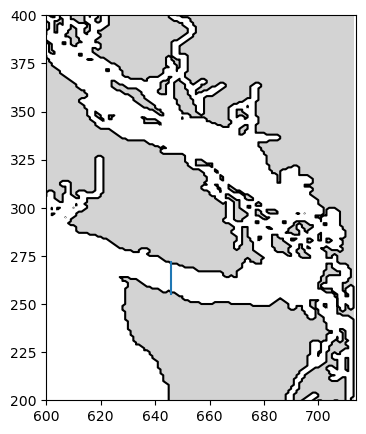

In [40]:
fig, ax = plt.subplots(figsize=(4, 5))
ax.contourf(mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim(600, 714)
ax.set_ylim(200,400)
ax.plot([646,646], [255,272])

In [79]:
file.init_y

<xarray.DataArray 'init_y' (ntraj: 1)>
array([376.01])
Dimensions without coordinates: ntraj
Attributes:
    title:     What is init_y ?
    longname:  Initial position in j
    units:     No dimension

In [58]:
def draw_patches(fmask, lonW, lonE, t_dist, t_depths): #draw ground part of cross section
    topo = []
    for i in range(lonW,lonE):
        for j in range(39):
            if fmask[j, i] == 0:
                rect = Rectangle((t_dist[i], t_depths[j]), t_dist[i+1]-t_dist[i], t_depths[j+1]-t_depths[j])
                topo.append(rect)
    pc = PatchCollection(topo, facecolors='burlywood', edgecolors='burlywood', zorder=3)
    return(pc)

<ipython-input-66-18dab6852df5>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  tmesh = ax1.pcolormesh(X,Y,data.T, cmap = cm.cm.balance, \


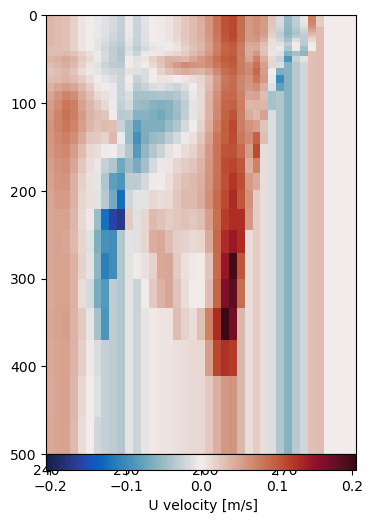

In [66]:
# nc_file = "/ocean/rbeutel/data/{:%Y%m}/U_new_{:%Y%m%d}.nc".format(date,date)
nc_to_plot = nc.Dataset(nc_file)
mesh = nc.Dataset('/ocean/mdunphy/CIOPSW-BC12/grid/mesh_mask_Bathymetry_NEP36_714x1020_SRTM30v11_NOAA3sec_WCTSS_JdeFSalSea.nc')

variable = 'vozocrtx'
fig, ax1= plt.subplots(nrows=1, ncols=1, figsize =(4,6))

igrid = 646-1
latS = 240
latN = 280

data = nc_to_plot[variable][0,igrid,latS:latN,:]
# X, Y = np.meshgrid(nc_to_plot['nav_lat'][646,255:273], nc_to_plot['depthu'])
section_slice = np.arange(latS,latN)
zlevels = mesh['gdept_1d'][:][0]
X, Y = np.meshgrid(section_slice, zlevels)
tmesh = ax1.pcolormesh(X,Y,data.T, cmap = cm.cm.balance, \
                      vmin = -1 * np.max(np.abs(data)), vmax = np.max(np.abs(data)))

mesh = xr.open_dataset('/ocean/mdunphy/CIOPSW-BC12/grid/mesh_mask_Bathymetry_NEP36_714x1020_SRTM30v11_NOAA3sec_WCTSS_JdeFSalSea.nc')

fmask = mesh.fmask[0, :, :, igrid]
t_lat = mesh.gphit[0,:,igrid]
m2lat = ((t_lat[latN]-t_lat[latS])/(mesh.e2t[0, latS:latN, igrid].sum()))
t_dist = t_lat/m2lat
t_depths = mesh.gdept_1d[0,:]
    
pc = draw_patches(fmask, latS, latN, np.array(t_dist), np.array(t_depths))
ax1.add_collection(pc)

ax1.set_ylim([0,500])
ax1.invert_yaxis()
cbar = fig.colorbar(tmesh, ax=ax1, orientation = 'horizontal',fraction=0.05, pad=0.0)#, ticks = tticks)
cbar.set_label(label=' U velocity [m/s]')

In [70]:
nc_to_plot[variable][0,igrid,latS,:] # this is land.. there should not be values...............

masked_array(data=[0.03834071, 0.03809441, 0.03808142, 0.03806797,
                   0.03805394, 0.03803922, 0.03802368, 0.0380072 ,
                   0.03798974, 0.0379713 , 0.03795206, 0.03793137,
                   0.03786975, 0.03761645, 0.03715863, 0.03392076,
                   0.03284725, 0.03795748, 0.03427751, 0.02844217,
                   0.03237327, 0.04090854, 0.04923234, 0.05465048,
                   0.05917945, 0.06108889, 0.06085335, 0.05811893,
                   0.05444082, 0.05283053, 0.05087579, 0.04912437,
                   0.0492321 , 0.04930348, 0.04759912, 0.04850748,
                   0.0471597 , 0.04630738, 0.0479382 , 0.05137384,
                   0.05275108, 0.05017483, 0.03874777, 0.03525363,
                   0.03492531, 0.03212914, 0.03565293, 0.02861615,
                   0.02861615, 0.02861615, 0.02861615, 0.02861615,
                   0.02861615, 0.02861615, 0.02861615, 0.02861615,
                   0.02861615, 0.02861615, 0.02861615, 0.02861

In [75]:
nc_to_plot[variable][0,igrid,267,:] # now this isnt land - but there shouldnt be data over the whole depth (should stop around 250 m)
#kind of looks like they start to repeat where they should not be a thing

masked_array(data=[0.05902149, 0.0576705 , 0.05765958, 0.05764834,
                   0.05763668, 0.05762454, 0.05761187, 0.05759865,
                   0.05758188, 0.0574891 , 0.05681896, 0.05552274,
                   0.05253756, 0.04369583, 0.03354806, 0.02820223,
                   0.03132209, 0.04393009, 0.05322982, 0.05359669,
                   0.05881594, 0.0425521 , 0.03246577, 0.03829902,
                   0.05177006, 0.03018421, 0.03284624, 0.01246764,
                   0.01246764, 0.01246764, 0.01246764, 0.01246764,
                   0.01246764, 0.01246764, 0.01246764, 0.01246764,
                   0.01246764, 0.01246764, 0.01246764, 0.01246764,
                   0.01246764, 0.01246764, 0.01246764, 0.01246764,
                   0.01246764, 0.01246764, 0.01246764, 0.01246764,
                   0.01246764, 0.01246764, 0.01246764, 0.01246764,
                   0.01246764, 0.01246764, 0.01246764, 0.01246764,
                   0.01246764, 0.01246764, 0.01246764, 0.01246

### Lets check on the new files

In [30]:
nc_file = "/ocean/rbeutel/data/u_new_23Nov15_SansEncoding.nc"
nc_to_plot = xr.open_dataset(nc_file)

In [31]:
nc_to_plot[variable][0,646,267,0]

<xarray.DataArray 'vozocrtx' ()>
array(0.076933)
Coordinates:
    time_counter  datetime64[ns] 2015-11-23T01:00:00
    nav_lat       float32 ...
    nav_lon       float32 ...
    depthu        float32 0.5075

In [32]:
np.max(np.abs(nc_to_plot[variable]))

<xarray.DataArray 'vozocrtx' ()>
array(2.95288837)

In [33]:
nc_file = "/ocean/rbeutel/data/u_new_23Nov15_WithEncodingBasic.nc"
nc_to_plot = xr.open_dataset(nc_file)

In [34]:
nc_to_plot[variable][0,646,267,0]

<xarray.DataArray 'vozocrtx' ()>
array(0.076933)
Coordinates:
    time_counter  datetime64[ns] 2015-11-23T01:00:00
    nav_lat       float32 ...
    nav_lon       float32 ...
    depthu        float32 0.5075

In [35]:
np.max(np.abs(nc_to_plot[variable]))

<xarray.DataArray 'vozocrtx' ()>
array(2.95288837)

well at least these are resonable values for velocity